<a href="https://colab.research.google.com/github/robpalinic/springboard-capstone-two/blob/main/Seattle_AirBnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

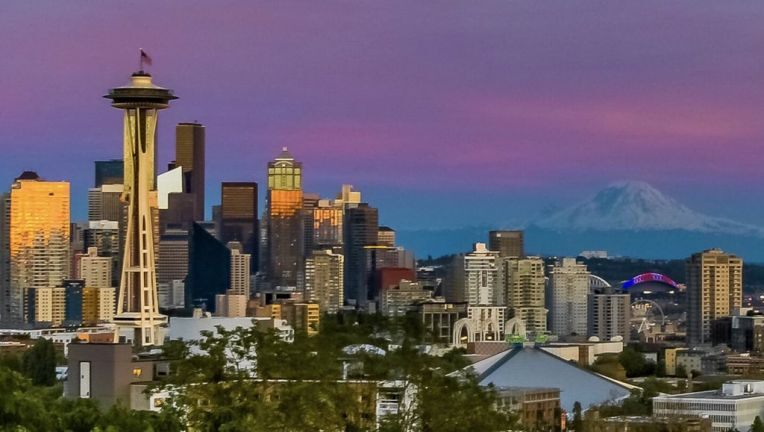

# **Optimizing the Seattle AirBnB market**

---


Hosts that have high occupancy rates (above 90%) may be underpricing their units, but may not know an ideal price to charge. Conversely, the rest of the market may have low occupancy due to factors under their control that they do not know about.

The goal is to create a model that can inform decision making to maximize overall revenue. The dataset will be segmented into neighbourhood and rental type, then further divided into two by high occupancy vs. regular units.

A model will then be trained on the non-90% occupancy units, or 'regular' units', to identify price and which features lead to higher prices. Ideally, these features will be controllable by the host. Both linear regression and random forest models will be built, with the most accurate model being chosen.

This model will then be applied to the high occupancy hosts and determine if they are priced well or below-market.

There will be two outputs from this project: recommended prices for high occupancy hosts, and potential improvements for regular hosts. The overall market will then be analyzed with potential changes.

## **Step 1: Data Collection**

---


Data was sourced from Kaggle, which had a dataset for one year for Seattle by listings from the year 2016.  Included is a separate file for reviews which is not needed for this analysis.

An important portion of this analysis will revolve around occupancy rates, which are not part of the data set. Analysis from insideairbnb.com, which analyzes AirBnB data, suggests that half of the guests leave reviews. Some data munging will most likely be necessary based on average reviews per month.

The original data: https://www.kaggle.com/airbnb/seattle

The Occupancy Model: http://insideairbnb.com/about.html#The%20Occupancy%20Model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
listings = pd.read_csv('/content/drive/MyDrive/Seattle AirBnb/listings.csv')

## **Step 2:  Data Definition**

---


Here we will get an idea of the data we have.  How many records, fields, data types, and what we are going to be able to use.

In our first step, we find that there are 92 fields (92!) and 3,818 records.  The fields can be broken into a few broad groups:
Host Information

*   Home Description and Characteristics
*   Reviews
*   Location
*   Pricing
*   Rules
*   Scraping information



Many of these fields are superfluous to building a model, or are redundant (three fields for neighbourhood, plus latitude and longtitude, etc.)  The obvious fields will be removed immediately during data cleansing, while the redundant fields will be examined and culled.












In [ ]:
listings.shape

(3818, 92)

In [ ]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [ ]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48



## **Step 3:  Data Cleansing**

---


The purpose of this step is identify records missing, unnecessary fields, fields that need formatting, and any categorical data which require changes.  I will be taking three different actions: removing fields, removing records, or altering records.

Cleansing will consist of several steps.  
, dealing with missing data, formatting of data, and outliers.

*   Removing unneeded fields
*   Formatting of data
*   Dealing with missing data
*   Removing Duplicates
*   Outliers




**3.1 Initial fields to remove**
Any field that is redundant (geographic data), text heavy or about the host will be removed as it will not assist analysis.


In [ ]:
listings.loc[0:5,'amenities']
#Looks to be TV, Internet, etc.  Will Remove this

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
5    {"Wireless Internet","Free Parking on Premises...
Name: amenities, dtype: object

In [ ]:
remove_fields = ['amenities', 'host_id', 'host_has_profile_pic', 'zipcode', 'market', 'smart_location', 'country_code', 
                 'country', 'longitude', 'latitude', 'is_location_exact', 'host_neighbourhood',
                 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 
                 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 
                 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_since', 
                 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count', 
                 'host_total_listings_count', 'host_verifications', 'host_identity_verified', 'street', 'city', 
                 'state','calendar_updated', 'has_availability', 'calendar_last_scraped', 'requires_license', 
                 'license', 'jurisdiction_names', 'calculated_host_listings_count', 'availability_90', 'availability_60', 'availability_30']

In [ ]:
listings = listings.drop(remove_fields, axis=1)
listings.shape

(3818, 41)

**3.2 Formatting changes**

Several fields with dollar amounts need to be changed to float, while the percentage needs to be converted to float.

In [ ]:
fields_to_float = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

for f in fields_to_float:
  listings[f] = pd.to_numeric(listings[f].str.strip(',$'), errors='coerce')

In [ ]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'), errors='coerce')/100

**3.3 Dealing with missing data**
	

In [ ]:
listings.isna().sum().sort_values(ascending=False)

square_feet                         3721
monthly_price                       3697
weekly_price                        2284
security_deposit                    2005
cleaning_fee                        1030
host_acceptance_rate                 773
review_scores_checkin                658
review_scores_accuracy               658
review_scores_value                  656
review_scores_location               655
review_scores_cleanliness            653
review_scores_communication          651
review_scores_rating                 647
reviews_per_month                    627
first_review                         627
last_review                          627
host_response_time                   523
host_response_rate                   523
neighbourhood                        416
bathrooms                             16
bedrooms                               6
host_is_superhost                      2
beds                                   1
price                                  1
property_type   

**3.3.1 Square Feet**

Just about every record is missing this field.  Drop the field.

In [ ]:
listings = listings.drop(['square_feet'], axis=1)

**3.3.2 Weekly and Monthly Rent**
Not all hosts have entered a weekly or monthly price.  For now, just multiply by 7 for weekly and 30.3 for monthly.

In [ ]:
missing_rent = listings[listings['weekly_price']!=listings['weekly_price']][['price', 'weekly_price', 'monthly_price']]
missing_rent.head()

,price,weekly_price,monthly_price
0,85.0,NaN,NaN
1,150.0,NaN,NaN
2,975.0,NaN,NaN
4,450.0,NaN,NaN
9,150.0,NaN,NaN


In [ ]:
print(listings['weekly_price'].head())
#Enter weekly and monthly prices
for i in range(len(listings)):
  if listings.loc[i, 'weekly_price'] != listings.loc[i, 'weekly_price']:
    listings.loc[i, 'weekly_price'] = listings.loc[i, 'price']*7
print(listings['weekly_price'].head())


for i in range(len(listings)):
  if listings.loc[i, 'monthly_price'] != listings.loc[i, 'monthly_price']:
    listings.loc[i, 'monthly_price'] = listings.loc[i, 'price']*30


0      NaN
1      NaN
2      NaN
3    650.0
4      NaN
Name: weekly_price, dtype: float64
0     595.0
1    1050.0
2    6825.0
3     650.0
4    3150.0
Name: weekly_price, dtype: float64


**3.3.3 Security Deposit and Cleaning Fee**

Both of these fields should be set to zero for no fee.

In [ ]:
#Security deposit set to zero.
print(listings['security_deposit'].head())

for i in range(len(listings)):
  if listings.loc[i, 'security_deposit'] != listings.loc[i, 'security_deposit']:
    listings.loc[i, 'security_deposit'] = 0

print(listings['security_deposit'].head())

0      NaN
1    100.0
2      NaN
3      NaN
4    700.0
Name: security_deposit, dtype: float64
0      0.0
1    100.0
2      0.0
3      0.0
4    700.0
Name: security_deposit, dtype: float64


In [ ]:
#Cleaning fee set to zero
print(listings['cleaning_fee'].head())

for i in range(len(listings)):
  if listings.loc[i, 'cleaning_fee'] != listings.loc[i, 'cleaning_fee']:
    listings.loc[i, 'cleaning_fee'] = 0

print(listings['cleaning_fee'].head())

0      NaN
1     40.0
2    300.0
3      NaN
4    125.0
Name: cleaning_fee, dtype: float64
0      0.0
1     40.0
2    300.0
3      0.0
4    125.0
Name: cleaning_fee, dtype: float64


**3.3.4 Host Acceptance Rate**

In [ ]:
#Investigate acceptance rate field
print(listings['host_acceptance_rate'].head())
listings['host_acceptance_rate'].value_counts()

#This field is either 100%, or nothing. Will drop this field.

0    100%
1    100%
2    100%
3     NaN
4     NaN
Name: host_acceptance_rate, dtype: object


100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

In [ ]:
listings = listings.drop('host_acceptance_rate', axis=1)

**3.3.5 Review Score**

It looks like if some review scores are missing they are all missing.  Best to remove all of these records.

In [ ]:
missing_review_scores = listings[listings['review_scores_checkin']!=listings['review_scores_checkin']]
missing_review_scores.head()

,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
3,7421966,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,100.0,650.0,3000.0,0.0,0.0,1,0.0,1,1125,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
18,7735464,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Private room,2,2.0,1.0,1.0,Futon,200.0,1400.0,6000.0,0.0,0.0,1,0.0,1,1125,125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
23,10106055,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,House,Private room,2,1.0,1.0,1.0,Real Bed,75.0,350.0,2250.0,0.0,0.0,1,0.0,1,1125,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
26,9025039,within a few hours,1.0,f,Queen Anne,West Queen Anne,Queen Anne,House,Entire home/apt,5,1.0,2.0,3.0,Real Bed,150.0,1050.0,4500.0,250.0,35.0,1,0.0,1,1125,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
46,9550869,within a day,0.9,f,Queen Anne,West Queen Anne,Queen Anne,Bungalow,Entire home/apt,10,3.0,4.0,4.0,Real Bed,349.0,2443.0,10470.0,0.0,200.0,1,0.0,1,1125,354,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,strict,f,f,NaN


In [ ]:
listings = listings[listings['review_scores_checkin']==listings['review_scores_checkin']]
listings.reset_index(inplace=True)
listings.shape

(3160, 40)

**3.3.6  Host Response Rate and Time**

Unknown why this data is missing, many of these listings are active.  I have to assume they just didn't have someone reach out.  Set these to 100% and 'Within an hour'

In [ ]:
listings['host_response_time'].head()

0    within a few hours
1        within an hour
2    within a few hours
3        within an hour
4                   NaN
Name: host_response_time, dtype: object

In [ ]:
missing_response_rate = listings[listings['host_response_time']!=listings['host_response_time']]
missing_response_rate.head(2)

,index,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
4,5,5956968,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,House,Private room,2,1.0,1.0,1.0,Real Bed,120.0,800.0,3600.0,0.0,40.0,1,30.0,1,6,302,17,2015-06-11,2015-09-28,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2.45
7,8,4948745,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,90.0,500.0,2700.0,0.0,0.0,1,0.0,3,1125,341,8,2015-06-22,2015-08-17,97.0,10.0,9.0,10.0,9.0,10.0,10.0,f,strict,f,f,1.22


In [ ]:
for i in range(len(listings)):
  if listings.loc[i, 'host_response_rate'] != listings.loc[i, 'host_response_rate']:
    listings.loc[i, 'host_response_rate'] = 1

In [ ]:
for i in range(len(listings)):
  if listings.loc[i, 'host_response_time'] != listings.loc[i, 'host_response_time']:
    listings.loc[i, 'host_response_time'] = 'within an hour'

**3.3.7 Last Review Time**
The data for the last review shows most listings had their reviews in 2015 or 2016.  Best to remove the older listings from 2014 and before.

In [ ]:
last= pd.to_datetime(listings['last_review'])
listings['year'] = last.dt.year
listings['year'].value_counts()

2015    2867
2016     215
2014      60
2013      11
2012       6
2011       1
Name: year, dtype: int64

In [ ]:
listings = listings[listings['year']>=2015]
listings['year'].value_counts()

2015    2867
2016     215
Name: year, dtype: int64

In [ ]:
listings = listings.drop(['first_review', 'last_review', 'year'], axis=1)

**3.3.9 Neighborhood**
The neighborhood field is missing values.  Luckily, there are two other neighborhood fields.  The neighborhood group cleansed field has 17 unique entries, while neighbourhood cleansed has 87.  I will be keeping the group field and dropping the other two.

In [ ]:
listings['neighbourhood_group_cleansed'].nunique()

17

In [ ]:
listings['neighbourhood_cleansed'].nunique()

87

In [ ]:
listings = listings.drop(['neighbourhood', 'neighbourhood_cleansed'], axis=1)
listings.shape

(3082, 36)

**3.3.10 Bathrooms, bedrooms, beds**

It is hard to believe there are no bathrooms, bedrooms, or beds in a listing.  Where the data is missing, we will enter a value of 1.

In [ ]:
print(listings.shape)
listings.reset_index(drop=True, inplace=True)

for i in range(len(listings)):
  if listings.loc[i, 'bathrooms'] != listings.loc[i, 'bathrooms']:
    listings.loc[i, 'bathrooms'] = 1

for i in range(len(listings)):
  if listings.loc[i, 'bedrooms'] != listings.loc[i, 'bedrooms']:
    listings.loc[i, 'bedrooms'] = 1

for i in range(len(listings)):
  if listings.loc[i, 'beds'] != listings.loc[i, 'beds']:
    listings.loc[i, 'beds'] = 1 

(3082, 36)


**3.3.11 Recap:  What is the state of the data**
After all this, there is only one missing value in the review_scores_value field.  All of its reviews are 10s, so we will manually change the missing value to 10.

We are left with 3082 records in 40 fields.

In [ ]:
listings.isna().sum().sort_values(ascending=False)

review_scores_value                 1
reviews_per_month                   0
accommodates                        0
weekly_price                        0
price                               0
bed_type                            0
beds                                0
bedrooms                            0
bathrooms                           0
room_type                           0
security_deposit                    0
property_type                       0
neighbourhood_group_cleansed        0
host_is_superhost                   0
host_response_rate                  0
host_response_time                  0
id                                  0
monthly_price                       0
cleaning_fee                        0
require_guest_phone_verification    0
review_scores_cleanliness           0
require_guest_profile_picture       0
cancellation_policy                 0
instant_bookable                    0
review_scores_location              0
review_scores_communication         0
review_score

In [ ]:
change = listings[listings['review_scores_value']!=listings['review_scores_value']].index
listings.loc[change, 'review_scores_value'] = 10

**3.5 Dedupe data**

It appears that there were no duplicates.

In [ ]:
listings.drop_duplicates()
print(listings.shape)

(3082, 36)


**3.6 Check for outliers.**

Taking the minimum and maximum of each field, nothing sticks out as being too high or too low, except for one home with a price of $999.  It doesn't appear to be an error, so it is left in.  Perhaps a 'luxury' condo.

I did notice that a property type had a yurt.  I investigated and found some other weird property types (dorm, treehouse) that won't help with the modeling. These will be removed, leaving only House and Apartment.  Townhomes will be rolled up into House, while Condo and Loft will roll up into Apartment.

When we look at listings by neighbourhood, we find some neighbourhoods just have too few listings to justify analysis.  We can remove these from the dataset.

In [ ]:
for col in listings.columns:
  print(col + ' min: ' + str(listings[col].min()) + ', max: ' + str(listings[col].max()))

index min: 0, max: 3814
id min: 4291, max: 10118341
host_response_time min: a few days or more, max: within an hour
host_response_rate min: 0.17, max: 1.0
host_is_superhost min: f, max: t
neighbourhood_group_cleansed min: Ballard, max: West Seattle
property_type min: Apartment, max: Yurt
room_type min: Entire home/apt, max: Shared room
accommodates min: 1, max: 16
bathrooms min: 0.0, max: 8.0
bedrooms min: 0.0, max: 7.0
beds min: 1.0, max: 15.0
bed_type min: Airbed, max: Real Bed
price min: 25.0, max: 999.0
weekly_price min: 100.0, max: 6993.0
monthly_price min: 500.0, max: 29970.0
security_deposit min: 0.0, max: 995.0
cleaning_fee min: 0.0, max: 300.0
guests_included min: 0, max: 13
extra_people min: 0.0, max: 300.0
minimum_nights min: 1, max: 1000
maximum_nights min: 1, max: 100000
availability_365 min: 0, max: 365
number_of_reviews min: 1, max: 474
review_scores_rating min: 20.0, max: 100.0
review_scores_accuracy min: 2.0, max: 10.0
review_scores_cleanliness min: 3.0, max: 10.0
revi

In [ ]:
listings[listings['price']==999]

,index,id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
982,1208,3345341,within a few hours,1.0,f,Downtown,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,999.0,6993.0,29970.0,95.0,85.0,1,10.0,1,31,0,54,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,moderate,f,f,2.89


In [ ]:
listings['property_type'].value_counts()

House              1414
Apartment          1392
Townhouse            80
Condominium          67
Loft                 33
Bed & Breakfast      25
Cabin                21
Other                18
Camper/RV            10
Bungalow              9
Tent                  4
Boat                  3
Treehouse             2
Dorm                  2
Chalet                1
Yurt                  1
Name: property_type, dtype: int64

In [ ]:
listings.loc[(listings['property_type'] == 'Townhouse'),'property_type'] = 'House'
listings.loc[(listings['property_type'] == 'Bungalow'),'property_type'] = 'House'

listings.loc[(listings['property_type'] == 'Condominium'),'property_type'] = 'Apartment'
listings.loc[(listings['property_type'] == 'Loft'),'property_type'] = 'Apartment'

to_drop = ['Bed & Breakfast', 'Cabin', 'Other', 'Camper/RV', 'Tent', 'Boat', 'Dorm', 'Treehouse', 'Chalet', 'Yurt']

listings = listings[~listings['property_type'].isin(to_drop)]

In [ ]:
listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    608
Downtown               438
Capitol Hill           436
Central Area           309
Queen Anne             238
Ballard                186
West Seattle           151
Rainier Valley         121
Beacon Hill             90
University District     89
Delridge                62
Northgate               61
Cascade                 61
Lake City               54
Magnolia                45
Seward Park             38
Interbay                 8
Name: neighbourhood_group_cleansed, dtype: int64

In [ ]:
neighbourhood_remove = ['Interbay', 'Seward Park', 'Magnolia', 'Lake City', 'Northgate', 'Cascade', 'Delridge']

listings = listings[~listings['neighbourhood_group_cleansed'].isin(neighbourhood_remove)]

**3.6 Final Data Frame**

We are now left with 36 fields and 2666 records.  This represents ten Seattle neighbourhoods, broken down into homes or apartments.


In [ ]:
listings.shape

(2666, 36)